In [ ]:
# Import necessary libraries
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest  # Import Isolation Forest

In [ ]:
# Load the synthetic dataset
data = pd.read_csv('/content/synthetic_network_traffic.csv')


In [ ]:

# Feature Engineering: Generate additional features (you can customize this)
data['TotalBytes'] = data['BytesSent'] + data['BytesReceived']
data['TotalPackets'] = data['PacketsSent'] + data['PacketsReceived']


In [ ]:
# Oversample the 'Anomaly' class to balance the class distribution
anomaly_data = data[data['IsAnomaly'] == 1]
oversampled_data = pd.concat([data, anomaly_data], axis=0)


In [ ]:
# Split the dataset into features and labels
X = oversampled_data.drop(columns=['IsAnomaly'])  # Features
y = oversampled_data['IsAnomaly']  # Labels

In [ ]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Create and fit the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Predict anomalies using the Isolation Forest
y_pred_iforest = isolation_forest.predict(X_test)
y_pred_iforest = (y_pred_iforest == -1)  # Convert -1 (anomaly) to 1, 1 (normal) to 0


In [ ]:
# Create the deep learning model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, use 'sigmoid' for anomaly detection
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Apply threshold (adjust as needed)

Epoch 1/5
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9842 - loss: nan - val_accuracy: 0.9904 - val_loss: nan
Epoch 2/5
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9899 - loss: nan - val_accuracy: 0.9904 - val_loss: nan
Epoch 3/5
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9902 - loss: nan - val_accuracy: 0.9904 - val_loss: nan
Epoch 4/5
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9898 - loss: nan - val_accuracy: 0.9904 - val_loss: nan
Epoch 5/5
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9902 - loss: nan - val_accuracy: 0.9904 - val_loss: nan
947/947 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'], zero_division=1)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


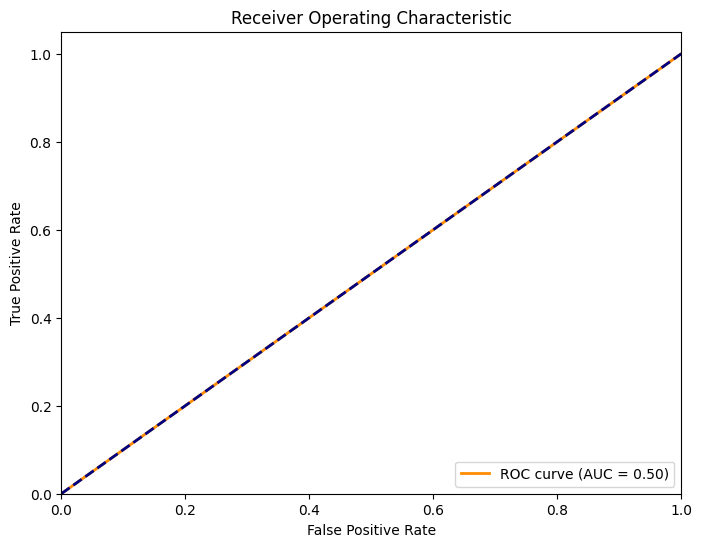

In [ ]:
# Visualize ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Confusion Matrix')

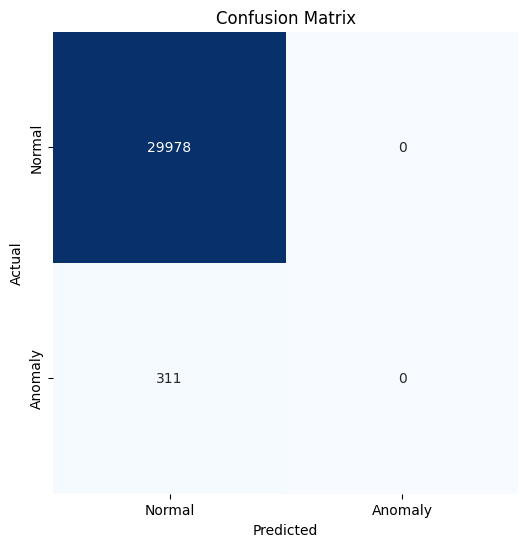

In [ ]:
# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')



In [ ]:
# Display Classification Report
print(report)

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     29978
     Anomaly       1.00      0.00      0.00       311

    accuracy                           0.99     30289
   macro avg       0.99      0.50      0.50     30289
weighted avg       0.99      0.99      0.98     30289



In [ ]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly,TotalBytes,TotalPackets
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,0.0,1.345076,0.297960
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0.0,-1.575119,-0.593777
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0.0,-1.040071,-0.224941
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.0,-1.011980,-3.287856
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0.0,-1.180483,1.400741


In [ ]:
df=pd.read_csv('/content/synthetic_network_traffic.csv')
print (df.columns)

Index(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort',
       'Protocol', 'BytesSent', 'BytesReceived', 'PacketsSent',
       'PacketsReceived', 'Duration', 'IsAnomaly'],
      dtype='object')


In [ ]:
print(df.shape)

(354267, 11)


In [ ]:
print(df.head())

   SourceIP  DestinationIP  SourcePort  DestinationPort  Protocol  BytesSent  \
0  0.496714      -0.138264    0.647689         1.523030 -0.234153  -0.234137   
1 -0.463418      -0.465730    0.241962        -1.913280 -1.724918  -0.562288   
2  1.465649      -0.225776    0.067528        -1.424748 -0.544383   0.110923   
3 -0.601707       1.852278   -0.013497        -1.057711  0.822545  -1.220844   
4  0.738467       0.171368   -0.115648        -0.301104 -1.478522  -0.719844   

   BytesReceived  PacketsSent  PacketsReceived  Duration  IsAnomaly  
0       1.579213     0.767435        -0.469474  0.542560        0.0  
1      -1.012831     0.314247        -0.908024 -1.412304        0.0  
2      -1.150994     0.375698        -0.600639 -0.291694        0.0  
3       0.208864    -1.959670        -1.328186  0.196861        0.0  
4      -0.460639     1.057122         0.343618 -1.763040        0.0  


In [ ]:
print(df.tail())

        SourceIP  DestinationIP  SourcePort  DestinationPort  Protocol  \
354262 -1.568305       0.568646    0.402424        -0.911086  0.188955   
354263 -1.260036      -0.183547    0.254754         0.175811  0.179505   
354264  1.257165       0.270050    0.912624         0.563804  0.978464   
354265 -0.569296      -1.155906   -0.953860        -0.871703  0.413942   
354266 -2.036849      -0.168849   -1.169320        -0.399344       NaN   

        BytesSent  BytesReceived  PacketsSent  PacketsReceived  Duration  \
354262  -0.481607       0.024762     0.063339         0.205801 -0.980746   
354263   0.524016      -0.537526    -1.635478         1.459423 -1.248840   
354264  -1.953079       0.290817     0.348136         1.245845  0.518330   
354265  -0.082114       2.287019     0.172264        -0.907673 -0.847215   
354266        NaN            NaN          NaN              NaN       NaN   

        IsAnomaly  
354262        0.0  
354263        0.0  
354264        0.0  
354265        0.0 

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354267 entries, 0 to 354266
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SourceIP         354267 non-null  float64
 1   DestinationIP    354267 non-null  float64
 2   SourcePort       354267 non-null  float64
 3   DestinationPort  354267 non-null  float64
 4   Protocol         354266 non-null  float64
 5   BytesSent        354266 non-null  float64
 6   BytesReceived    354266 non-null  float64
 7   PacketsSent      354266 non-null  float64
 8   PacketsReceived  354266 non-null  float64
 9   Duration         354266 non-null  float64
 10  IsAnomaly        354266 non-null  float64
dtypes: float64(11)
memory usage: 29.7 MB
None


In [ ]:
print(df.describe())

            SourceIP  DestinationIP     SourcePort  DestinationPort  \
count  354267.000000  354267.000000  354267.000000    354267.000000   
mean        0.000338       0.001393      -0.006021         0.000352   
std         0.999725       1.000218       1.000625         1.000913   
min        -4.980146      -4.520892      -4.829436        -4.644419   
25%        -0.674857      -0.672996      -0.682054        -0.674506   
50%         0.001832       0.000628      -0.006965         0.000683   
75%         0.673275       0.675126       0.668166         0.674269   
max         5.032374       4.984215       4.528914         4.659490   

            Protocol      BytesSent  BytesReceived    PacketsSent  \
count  354266.000000  354266.000000  354266.000000  354266.000000   
mean        0.001176       0.000423       0.000888      -0.001030   
std         1.001209       1.000972       1.000650       0.999103   
min        -4.596948      -4.573550      -4.462969      -4.319465   
25%        -0.6

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
354262,False
354263,False
354264,False
354265,False


In [ ]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [SourceIP, DestinationIP, SourcePort, DestinationPort, Protocol, BytesSent, BytesReceived, PacketsSent, PacketsReceived, Duration, IsAnomaly]
Index: []


In [ ]:
df.drop_duplicates()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,0.0
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0.0
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0.0
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.0
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0.0
...,...,...,...,...,...,...,...,...,...,...,...
354262,-1.568305,0.568646,0.402424,-0.911086,0.188955,-0.481607,0.024762,0.063339,0.205801,-0.980746,0.0
354263,-1.260036,-0.183547,0.254754,0.175811,0.179505,0.524016,-0.537526,-1.635478,1.459423,-1.248840,0.0
354264,1.257165,0.270050,0.912624,0.563804,0.978464,-1.953079,0.290817,0.348136,1.245845,0.518330,0.0
354265,-0.569296,-1.155906,-0.953860,-0.871703,0.413942,-0.082114,2.287019,0.172264,-0.907673,-0.847215,0.0


In [ ]:
duplicate_columns= df[df.duplicated()]
print(duplicate_columns)

Empty DataFrame
Columns: [SourceIP, DestinationIP, SourcePort, DestinationPort, Protocol, BytesSent, BytesReceived, PacketsSent, PacketsReceived, Duration, IsAnomaly]
Index: []


In [ ]:
data.isna().sum()

,0
SourceIP,0
DestinationIP,0
SourcePort,0
DestinationPort,0
Protocol,0
BytesSent,0
BytesReceived,0
PacketsSent,1
PacketsReceived,1
Duration,1


In [ ]:
df = pd.DataFrame(data)

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [ ]:
print("DataFrame after removing outliers using IQR:")
print(df)

DataFrame after removing outliers using IQR:
        SourceIP  DestinationIP  SourcePort  DestinationPort  Protocol  \
0       0.496714      -0.138264    0.647689         1.523030 -0.234153   
1      -0.463418      -0.465730    0.241962        -1.913280 -1.724918   
2       1.465649      -0.225776    0.067528        -1.424748 -0.544383   
3      -0.601707       1.852278   -0.013497        -1.057711  0.822545   
4       0.738467       0.171368   -0.115648        -0.301104 -1.478522   
...          ...            ...         ...              ...       ...   
200921 -0.359081       0.403997   -0.763979        -0.078592 -0.577414   
200922 -1.261247      -1.374903    1.373136        -1.416191 -0.411088   
200923 -1.592335       0.203070    0.227498        -0.559522  0.558366   
200924 -0.642915      -1.208405   -2.211946        -1.579491 -0.866288   
200925  2.115778       1.308781    1.268466        -0.685449 -0.376572   

        BytesSent  BytesReceived  PacketsSent  PacketsReceived  Du

In [ ]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [ ]:
print(data)

        SourceIP  DestinationIP  SourcePort  DestinationPort  Protocol  \
0       0.495589      -0.139180    0.654750         1.523117 -0.233791   
1      -0.465147      -0.466149    0.249448        -1.906194 -1.726176   
2       1.465134      -0.226559    0.075197        -1.418657 -0.544357   
3      -0.603522       1.848351   -0.005743        -1.052367  0.824057   
4       0.737494       0.169984   -0.107787        -0.297301 -1.479512   
...          ...            ...         ...              ...       ...   
200921 -0.360744       0.402261   -0.755439        -0.075243 -0.577424   
200922 -1.263478      -1.373947    1.379437        -1.410117 -0.410917   
200923 -1.594774       0.201638    0.234999        -0.555193  0.559590   
200924 -0.644757      -1.207701   -2.201888        -1.573085 -0.866612   
200925  2.115672       1.305676    1.274877        -0.680864 -0.376364   

        BytesSent  BytesReceived  PacketsSent  PacketsReceived  Duration  \
0       -0.233449       1.576669   

In [ ]:
num_df = data.select_dtypes(include="number")
cat_df = data.select_dtypes(include="object_")
final_df = pd.concat([num_df, cat_df], axis=1)

['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'Protocol', 'BytesSent', 'BytesReceived', 'PacketsSent', 'PacketsReceived', 'Duration', 'IsAnomaly', 'TotalBytes', 'TotalPackets']


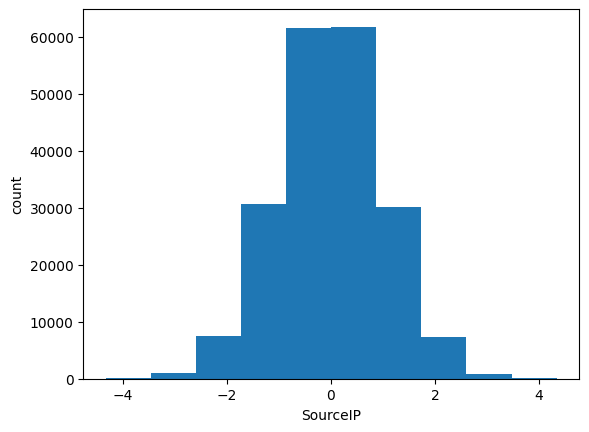

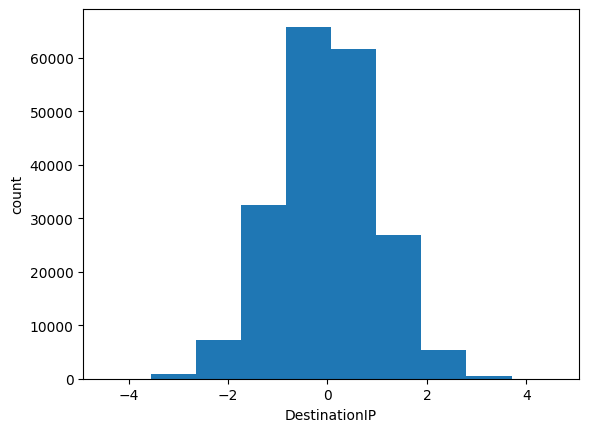

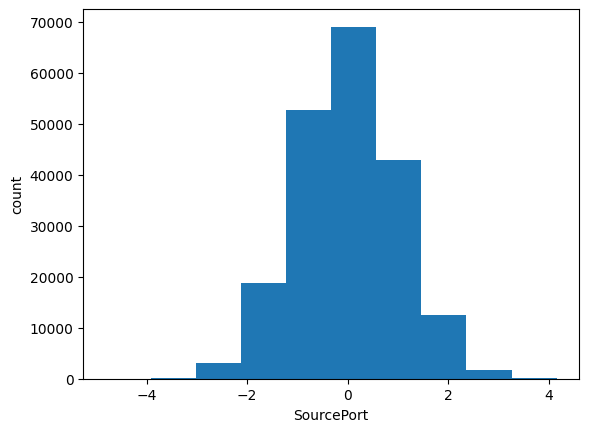

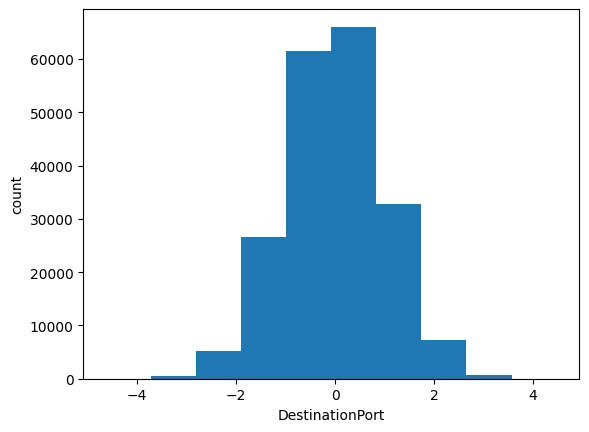

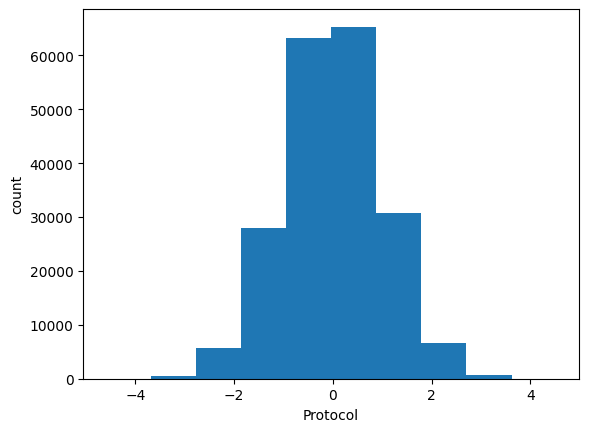

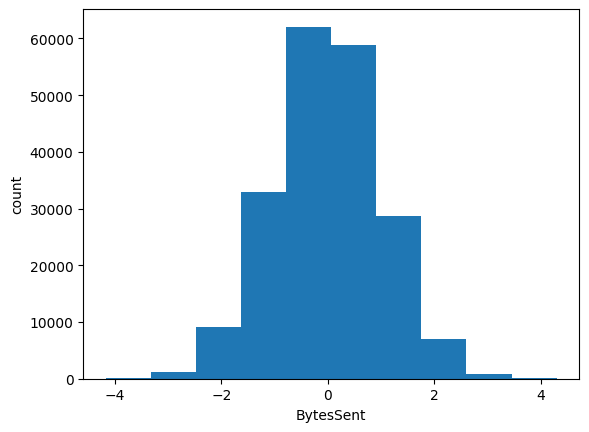

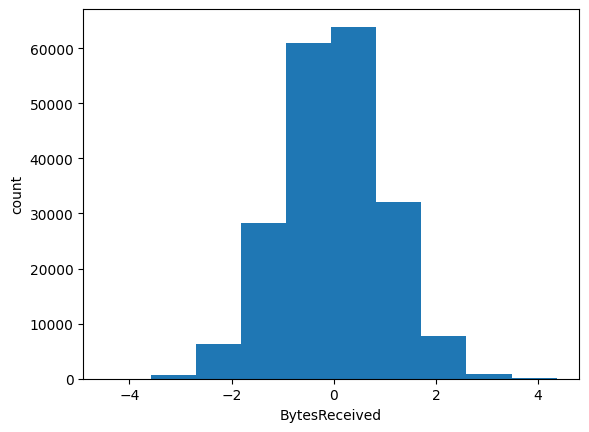

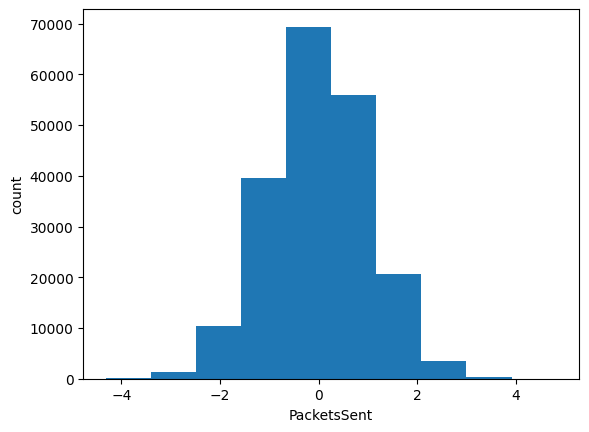

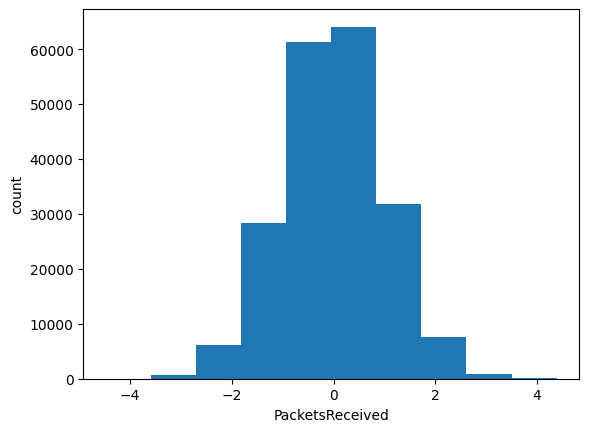

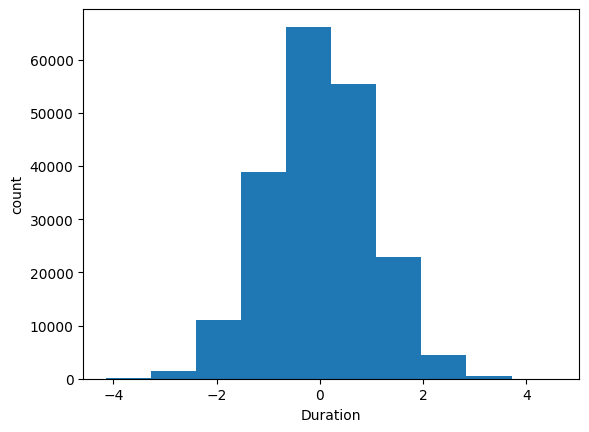

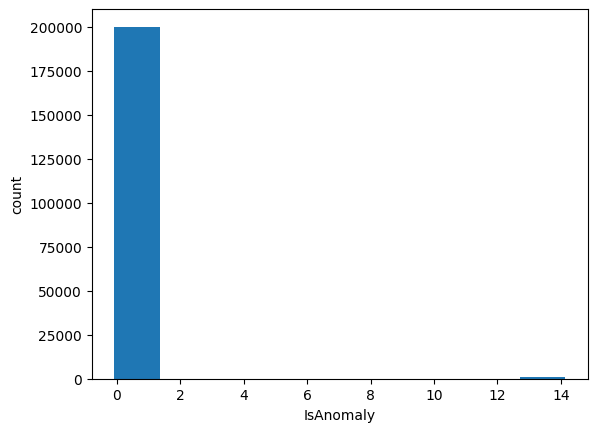

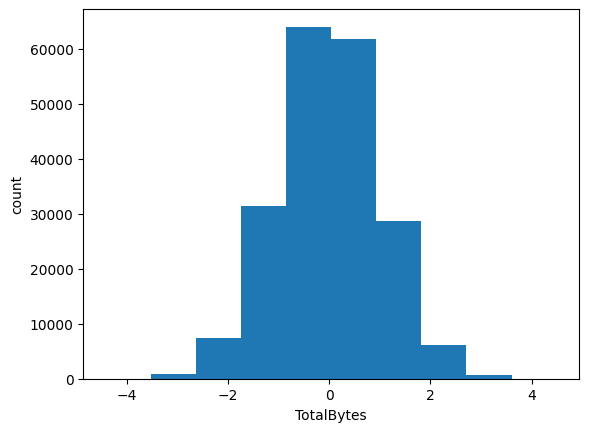

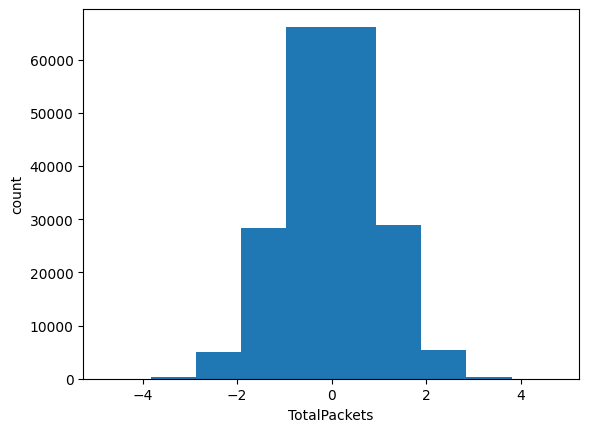

In [ ]:
num_cols = num_df.columns.tolist()
print(num_cols)
for col in num_cols:
  plt.hist(num_df[col])
  plt.xlabel(col)
  plt.ylabel("count")
  plt.show()

In [ ]:
for col in num_cols:
  num_df[col] = num_df[col].fillna(num_df[col].median())

In [ ]:
num_df.isna().sum()

,0
SourceIP,0
DestinationIP,0
SourcePort,0
DestinationPort,0
Protocol,0
BytesSent,0
BytesReceived,0
PacketsSent,0
PacketsReceived,0
Duration,0


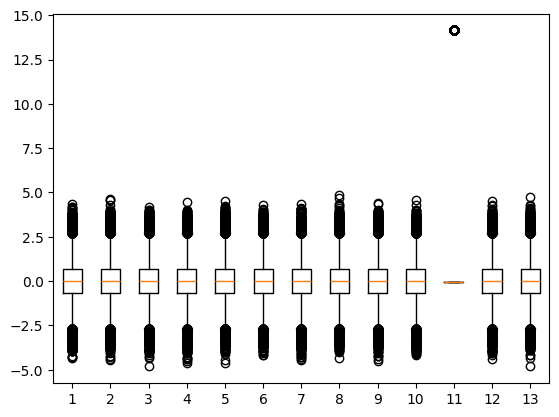

In [ ]:
plt.boxplot(num_df)
plt.show()

In [ ]:
def replace_outliers_with_upper_bound(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    df[column_name] = df[column_name].clip(upper=upper_bound)
    df[column_name] = df[column_name].clip(lower=lower_bound)
    return df[column_name]

In [ ]:
for col in num_cols:
  num_df[col] = replace_outliers_with_upper_bound(num_df, col)

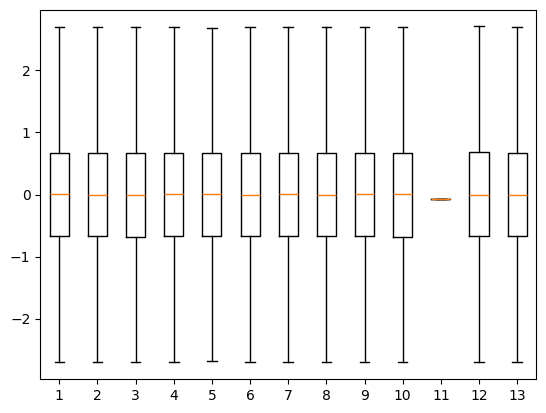

In [ ]:
plt.boxplot(num_df)
plt.show()

In [ ]:
for col in num_cols[:-1]:
  num_df[col] = (num_df[col]-num_df[col].min())/(num_df[col].max()-num_df[col].min())

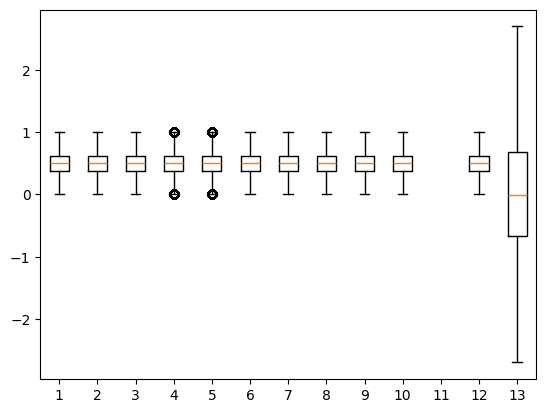

In [ ]:
plt.boxplot(num_df)
plt.show()

In [ ]:
cat_df.head(2)

""
0
1


In [ ]:
cat_cols = cat_df.columns.tolist()

In [ ]:
for col in cat_cols:
  print(cat_df[col].value_counts())

In [ ]:
data = data.fillna(0)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
y = y.apply(lambda x: 1 if x == 'Anomalous' else 0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print("\nData Split Completed:")
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")


Data Split Completed:
Training Data Shape: (141348, 12), Testing Data Shape: (60578, 12)


In [ ]:
train_preds = model.predict(X_train)
train_preds = np.where(train_preds == -1, 1, 0)  # Convert -1 (anomaly) to 1 and 1 (normal) to 0



In [ ]:
test_preds = model.predict(X_test)
test_preds = np.where(test_preds == -1, 1, 0)

In [ ]:
print("\nEvaluation on Training Data:")
print(classification_report(y_train, train_preds))


Evaluation on Training Data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    141348
           1       0.00      0.00      0.00         0

    accuracy                           0.95    141348
   macro avg       0.50      0.47      0.49    141348
weighted avg       1.00      0.95      0.97    141348



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\nEvaluation on Testing Data:")
print(classification_report(y_test, test_preds))


Evaluation on Testing Data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     60578
           1       0.00      0.00      0.00         0

    accuracy                           0.95     60578
   macro avg       0.50      0.48      0.49     60578
weighted avg       1.00      0.95      0.97     60578



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


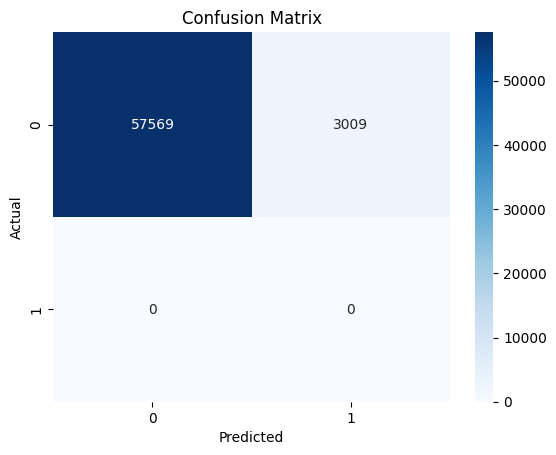

In [ ]:
cm = confusion_matrix(y_test, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, test_preds)
print(f"AUC-ROC Score: {auc:.2f}")

AUC-ROC Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import joblib

# Assuming 'isolation_forest' is your trained IsolationForest model
joblib.dump(isolation_forest, 'isolationforest_model.pkl')
print("Model saved as isolationforest_model.pkl")


Model saved as isolationforest_model.pkl


In [ ]:
import joblib

# Assuming 'isolation_forest' is your trained IsolationForest model
joblib.dump(isolation_forest, 'isolationforest_model.pkl')
print("Model saved as isolationforest_model.pkl")


Model saved as isolationforest_model.pkl


In [ ]:
import joblib
joblib.dump(model, '/content/isolationforest_model.pkl')  # Save model
print("\nModel saved to Google Drive.")


Model saved to Google Drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': test_preds})
results.to_csv('/content/drive/MyDrive/Anomaly_Detection_Results.csv', index=False)  # Save predictions
print("Results saved to Google Drive.")

Results saved to Google Drive.


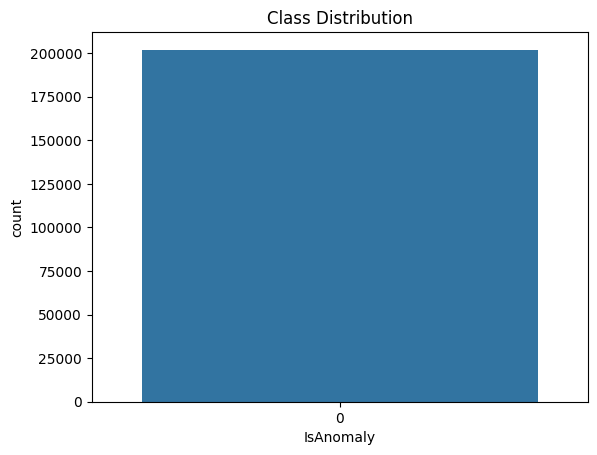

In [ ]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()


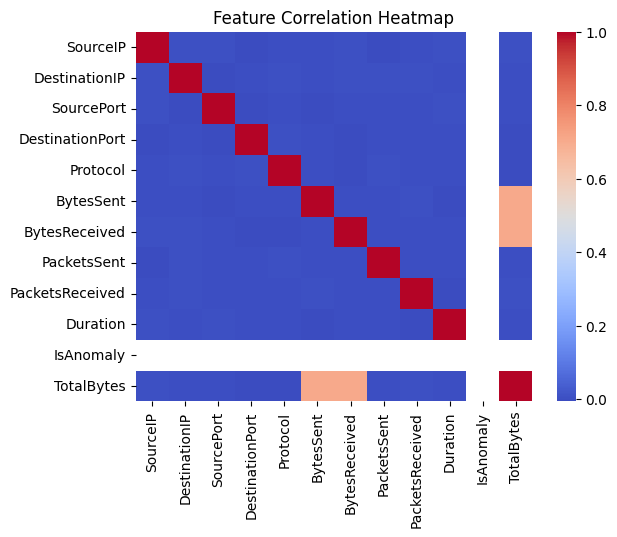

In [ ]:
correlation_matrix = pd.DataFrame(X, columns=data.columns[:-1]).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()